In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_40DLorenz.recursive_Markovian_PostMeanScore_40DLorenz_Chaos_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 1024
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [11]:
import pandas as pd
def get_drift_files_nonfull(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/{config.ndims}DLnzChaosLessData/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "MSEs" not in file and "bwidx" in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                print(mses_full)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

          bw         mse
38  7.852356  486.035095
          bw          mse
18  0.041919  9984.698242
            bw         mse
52  398.107171  849.949036
          bw          mse
26  0.387196  1552.452637
         bw         mse
37  6.16595  370.339722
            bw         mse
51  251.188643  849.658386
          bw           mse
10  0.004538  10239.998047
         bw           mse
0  0.000282  10242.397461
          bw           mse
13  0.010446  10228.030273
          bw           mse
17  0.031749  10096.621094
         bw  mse
59  10000.0  0.0
           bw         mse
47  63.095734  842.512085
           bw         mse
43  25.118864  802.975403
           bw        mse
41  15.848932  736.27002
          bw          mse
25  0.293252  3268.184326
          bw         mse
27  0.511235  584.839539
            bw         mse
50  158.489319  848.928467
           bw         mse
44  31.622777  820.109558
          bw           mse
12  0.007912  10234.246094
             bw         ms

Text(0.5, 1.0, 'Minimum MSE is (0.0, 57)')

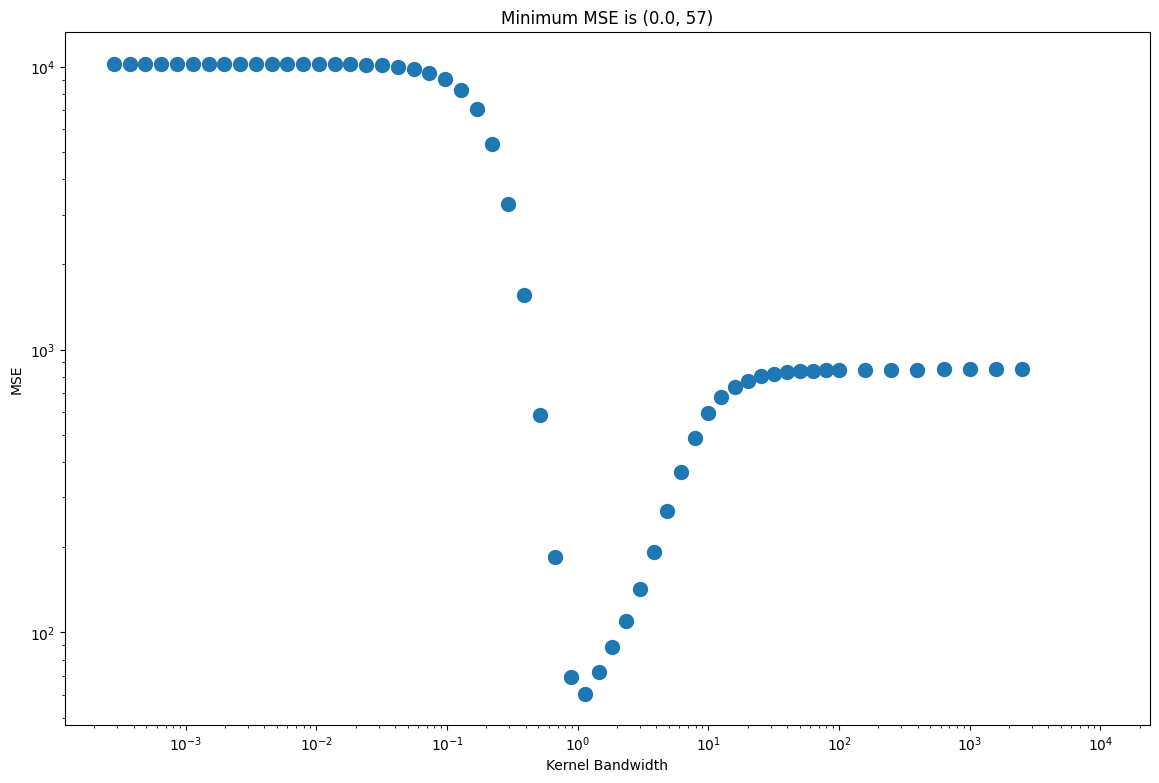

In [12]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files_nonfull(config=config, root_dir=root_dir)
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")

Text(0.5, 1.0, 'Minimum MSE is (0.0, 57)')

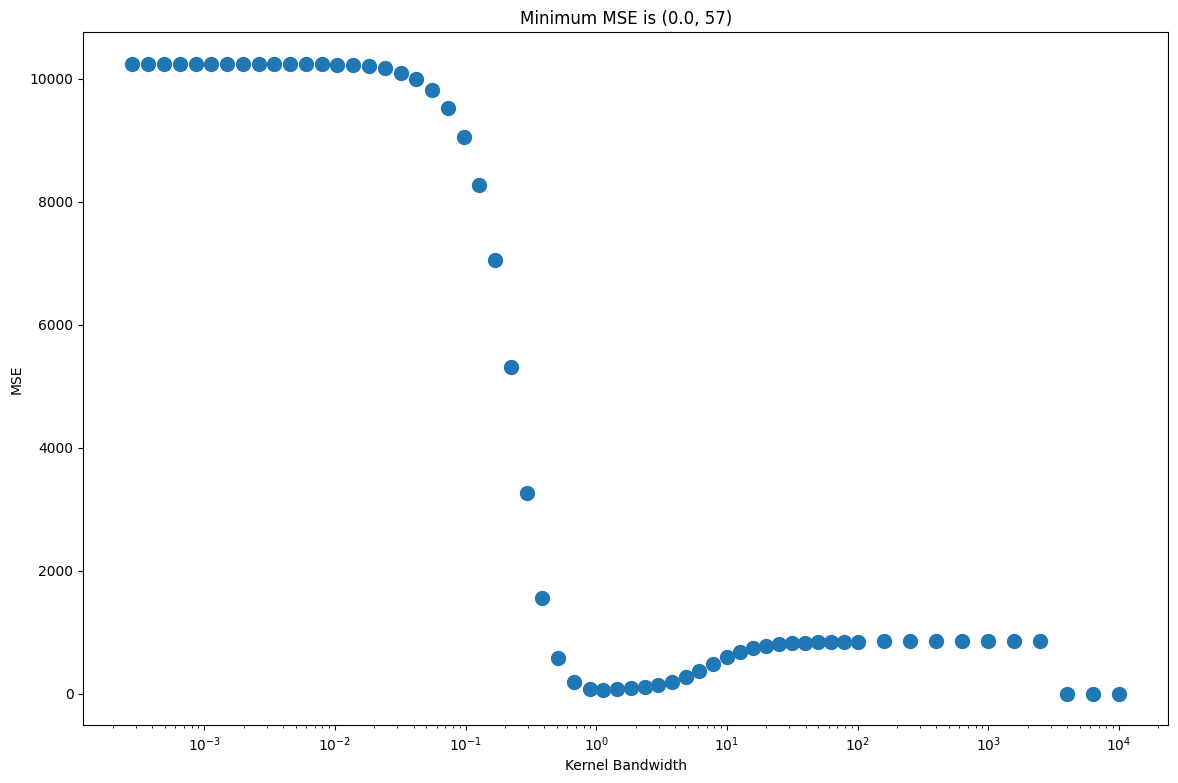

In [13]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")

In [16]:
print(mses)

              bw           mse
0       0.000282  10242.397461
1       0.000372  10242.324219
2       0.000491  10242.041016
3       0.000649  10242.466797
4       0.000857  10242.186523
5       0.001131  10242.453125
6       0.001493  10242.136719
7       0.001972  10241.942383
8       0.002603  10241.469727
9       0.003437  10241.119141
10      0.004538  10239.998047
11      0.005992  10238.124023
12      0.007912  10234.246094
13      0.010446  10228.030273
14      0.013793  10217.516602
15      0.018211  10199.197266
16      0.024046  10164.253906
17      0.031749  10096.621094
18      0.041919   9984.698242
19      0.055348   9806.870117
20      0.073079   9519.322266
21      0.096490   9047.213867
22      0.127401   8273.513672
23      0.168214   7054.798340
24      0.222102   5311.565430
25      0.293252   3268.184326
26      0.387196   1552.452637
27      0.511235    584.839539
28      0.675010    184.414169
29      0.891251     69.358788
30      1.135011     60.808136
31      

In [14]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.nanmean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/40DLnzChaosLessData/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [15]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/resource_logging/trained_rec_PM_ST_1000FTh_MLP_2LFac_NSTgtNFMReg_40DLnz_125e+00FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110.json.json'